# 1: Librerie
Importazione di tutte le librerie necessarie per la gestione del dataset, la costruzione del modello e l'apprendimento della rete.

* `tensorflow`: Funzioni di creazione del modello, e di gestione della fase di training.
* `numpy`: Gestione di array e funzioni di calcolo.
* `pandas`: Funzioni di apertura e parsing del dataset.
* `matplotlib`: Funzioni di gestione dei grafici, per la visualizzazione dei risultati in fase di training.

In [12]:
"""
Install dependencies:
>>> pip install --upgrade pip
>>> pip install numpy pandas matplotlib seaborn scikit-learn tensorflow 
"""

'\nInstall dependencies:\n>>> pip install --upgrade pip\n>>> pip install numpy pandas matplotlib seaborn scikit-learn tensorflow \n'

In [13]:
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.layers     as layers
import tensorflow.keras.models     as models
import tensorflow.keras.backend    as K
import pandas                      as pd
import numpy                       as np
import matplotlib.pyplot           as plt

from tensorflow.keras.callbacks            import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.model_selection               import train_test_split
from sklearn.preprocessing                 import LabelEncoder as le
from sklearn.metrics                       import confusion_matrix, ConfusionMatrixDisplay

## Variabili globali
* `num_layers`: Configurazione degli strati della rete. Aggiungendo e rimuovendo neuroni, è possibile modificare la rete.
    * Ogni elemento di `num_layers` dovrebbe essere un array di 3 elementi: numero di neuroni nello strato, funzione di attivazione, larghezza del dropout.
* `num_epochs`: Numero di epoche di training del modello.
* `batch_size`: Larghezza dei batch durante la fase di training.

In [14]:
net_layers = [
    [16, 'relu', 0.1]  for _ in range(1)] + [
    [32, 'relu', 0.1] for _ in range(2)
]
num_epochs = 450 # Number of epochs
batch_size = 24  # Batch size

# 2: Dataset augmentation function


In [15]:
def dataset_augmentation(dataset, target_count, column_augmentation):

    col_key = column_augmentation[0] # key column for filtering
    col_val = column_augmentation[1] # value to filter by
    samples = dataset[dataset[col_key] == col_val].copy() # filter samples
    
    # check if there are any samples to augment
    if len(samples) == 0:
        print(f"WARNING: No samples found for {col_val} in column {col_key} for data augmentation.")
        return dataset
    
    # check if the number of samples is already sufficient
    if len(samples) >= target_count:
        print(f"WARNING: Number of samples for {col_val} in column {col_key} ({len(samples)}) is already sufficient.")
        return dataset
    
    print(f"Number of samples found: {len(samples)}")
    print(f"Target number of values for {col_val}: {target_count}")

    num_cols = samples.keys()[1 : -1] # skip first and last column (not numeric features)
    
    synthetic_samples = []
    samples_needed    = target_count - len(samples)
    
    for _ in range(samples_needed):

        base_sample = samples.sample(n = 1).iloc[0].copy() # base sample from 'Old' samples
        
        for col in num_cols: # add noise to numeric columns
            noise_factor     = np.random.uniform(0.06, 0.23)
            noise            = np.random.normal(0, base_sample[col] * noise_factor)
            base_sample[col] = max(0, base_sample[col] + noise) # ensure no negative values
        
        synthetic_samples.append(base_sample) # append modified sample to list
    
    # convert list of synthetic samples to DataFrame
    synthetic_df      = pd.DataFrame(synthetic_samples)
    augmented_dataset = pd.concat([dataset, synthetic_df], ignore_index = True)
    
    print(f"Number of samples after augmentation: {len(augmented_dataset)}")
    
    return augmented_dataset # return augmented dataset with synthetic samples

In [16]:
def class_weights(dataset, target_column):
    """
    Calculate class weights for imbalanced dataset.
    """
    class_counts = dataset[target_column].value_counts()
    total_count  = len(dataset)
    
    # Calculate weights inversely proportional to class frequencies
    weights = {cls: total_count / (len(class_counts) * count) for cls, count in class_counts.items()}
    print(f"Class weights: {weights}")
    return weights

In [17]:
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)
    return focal_loss_fixed

# 3: Dataset
Importazione del dataset e divisione delle istanze per validation, training e testing.

## Obiettivo del modello
Classificazione dell'età di un *abalone*, a seconda delle misure fisiche effettuate.

* Elementi del dataset: **4177** istanze
    * Implementazione di data augmentation per compensare lo sbilanciamento
* Features disponibili: **8** colonne
* Classificazione: **3** classi

In [18]:
try:

    dataset_name   = "Dataset.csv"                      # specify the dataset file name
    dataset        = pd.read_csv(f"./{dataset_name}")   # load the dataset
    dataset['Sex'] = le().fit_transform(dataset['Sex']) # label encoding for column 'Sex'
    
    column = 'Age'
    for val in dataset[column].unique(): # Dataset augmentation
        dataset = dataset_augmentation(dataset, target_count = 2500, column_augmentation = [column, val])
        
    weights = class_weights(dataset, target_column = column) # calculate class weights

    # One-hot encoding for column 'Age'
    dataset    = pd.get_dummies(dataset, columns = [column], prefix = column)
    dummy_cols = [col for col in dataset.columns if col.startswith(f'{column}_')]

    # Separate features and labels
    Y = dataset[dummy_cols]
    X = dataset.drop(columns = dummy_cols)

    # First split: 70% train, 30% combined validation and test
    X_train, X_comb, Y_train, Y_comb = train_test_split(X, Y, test_size = 0.3, random_state = 42)

    # Second split: 65% validation, 35% test from the combined set
    X_val, X_test, Y_val, Y_test = train_test_split(X_comb, Y_comb, test_size = 0.35, random_state = 42)

    print()
    print("Training set shape:  ", X_train.shape, Y_train.shape)
    print("Validation set shape:", X_val.shape, Y_val.shape)
    print("Test set shape:      ", X_test.shape, Y_test.shape)
except FileNotFoundError:
    print(f"ERROR: File not found. Please ensure the file '{dataset_name}' is in working directory.")

Number of samples found: 2045
Target number of values for MiddleAge: 2500
Number of samples after augmentation: 4632
Number of samples found: 2096
Target number of values for Young: 2500
Number of samples after augmentation: 5036
Number of samples found: 36
Target number of values for Old: 2500
Number of samples after augmentation: 7500
Class weights: {'MiddleAge': 1.0, 'Young': 1.0, 'Old': 1.0}

Training set shape:   (5250, 8) (5250, 3)
Validation set shape: (1462, 8) (1462, 3)
Test set shape:       (788, 8) (788, 3)


# 4: Creazione del modello
Generazione di un modello di rete neurale.

In [19]:
model = models.Sequential([layers.Input(shape = (X_train.shape[1],))]) # Input layer

for layer in net_layers: # Add hidden layers
    model.add(layers.Dense(layer[0], activation = layer[1])) # Dense layer
    if (layer[2] > 0):
        model.add(layers.Dropout(layer[2]))                  # Dropout layer
    model.add(layers.BatchNormalization())                   # Batch normalization layer
    
model.add(layers.Dense(Y_train.shape[1], activation = 'softmax')) # Output layer

model.summary() # Print the model summary

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,163 (8.45 KB)

 Trainable params: 2,003 (7.82 KB)

 Non-trainable params: 160 (640.00 B)

## 5: Compilazione e training del modello generato

In [20]:
lr_decay = ExponentialDecay(
    initial_learning_rate = 3e-4, # Starting learning rate
    decay_steps           = 1e3, # Number of steps before decay
    decay_rate            = 1  # Multiplicative decay factor
)

model.compile(
    optimizer = optimizers.Adam(learning_rate = lr_decay),
    loss      = focal_loss(gamma = 1.85, alpha = 0.3), # Focal loss for imbalanced datasets
    metrics   = ['accuracy', 'Precision', 'Recall']
)

early_stop = EarlyStopping(
    monitor              = 'val_loss',
    patience             = 25,
    restore_best_weights = True
)

reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor   = 0.5,
    patience = 5,
    min_lr   = 1e-6
)

In [21]:
history = model.fit(
    X_train, Y_train,
    epochs          = num_epochs,     # Number of epochs
    shuffle         = True,           # Shuffle the data
    batch_size      = batch_size,     # Batch size
    validation_data = (X_val, Y_val), # Validation data
    callbacks       = [early_stop],   # Callbacks
    #class_weight    = weights         # Class weights for imbalanced dataset  
)

Epoch 1/450
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - Precision: 0.4615 - Recall: 0.3633 - accuracy: 0.4425 - loss: 0.2667 - val_Precision: 0.5803 - val_Recall: 0.3263 - val_accuracy: 0.5219 - val_loss: 0.1373
Epoch 2/450
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Precision: 0.5554 - Recall: 0.4017 - accuracy: 0.5070 - loss: 0.1819 - val_Precision: 0.6287 - val_Recall: 0.3810 - val_accuracy: 0.5561 - val_loss: 0.1214
Epoch 3/450
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Precision: 0.5843 - Recall: 0.3950 - accuracy: 0.5310 - loss: 0.1562 - val_Precision: 0.7374 - val_Recall: 0.3707 - val_accuracy: 0.6211 - val_loss: 0.1101
Epoch 4/450
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Precision: 0.6172 - Recall: 0.4022 - accuracy: 0.5446 - loss: 0.1429 - val_Precision: 0.7672 - val_Recall: 0.3584 - val_accuracy: 0.6156 - val_loss: 0.1063
Epoch 5/450
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Precision: 0.6130 - Recall: 0.3807 - accuracy: 0.5464 - loss: 0.1326 - val_Precision: 0.7709 - val_Re

## 6: Visualizzazione dei risultati

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.8359 - Recall: 0.6514 - accuracy: 0.7565 - loss: 0.0639 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Test set evaluation:
Precision: 0.8320
Recall:    0.6472
Loss:      0.0669
Accuracy:  0.7614
F1-score:  0.7281


/tmp/ipykernel_270486/2046652487.py:191: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


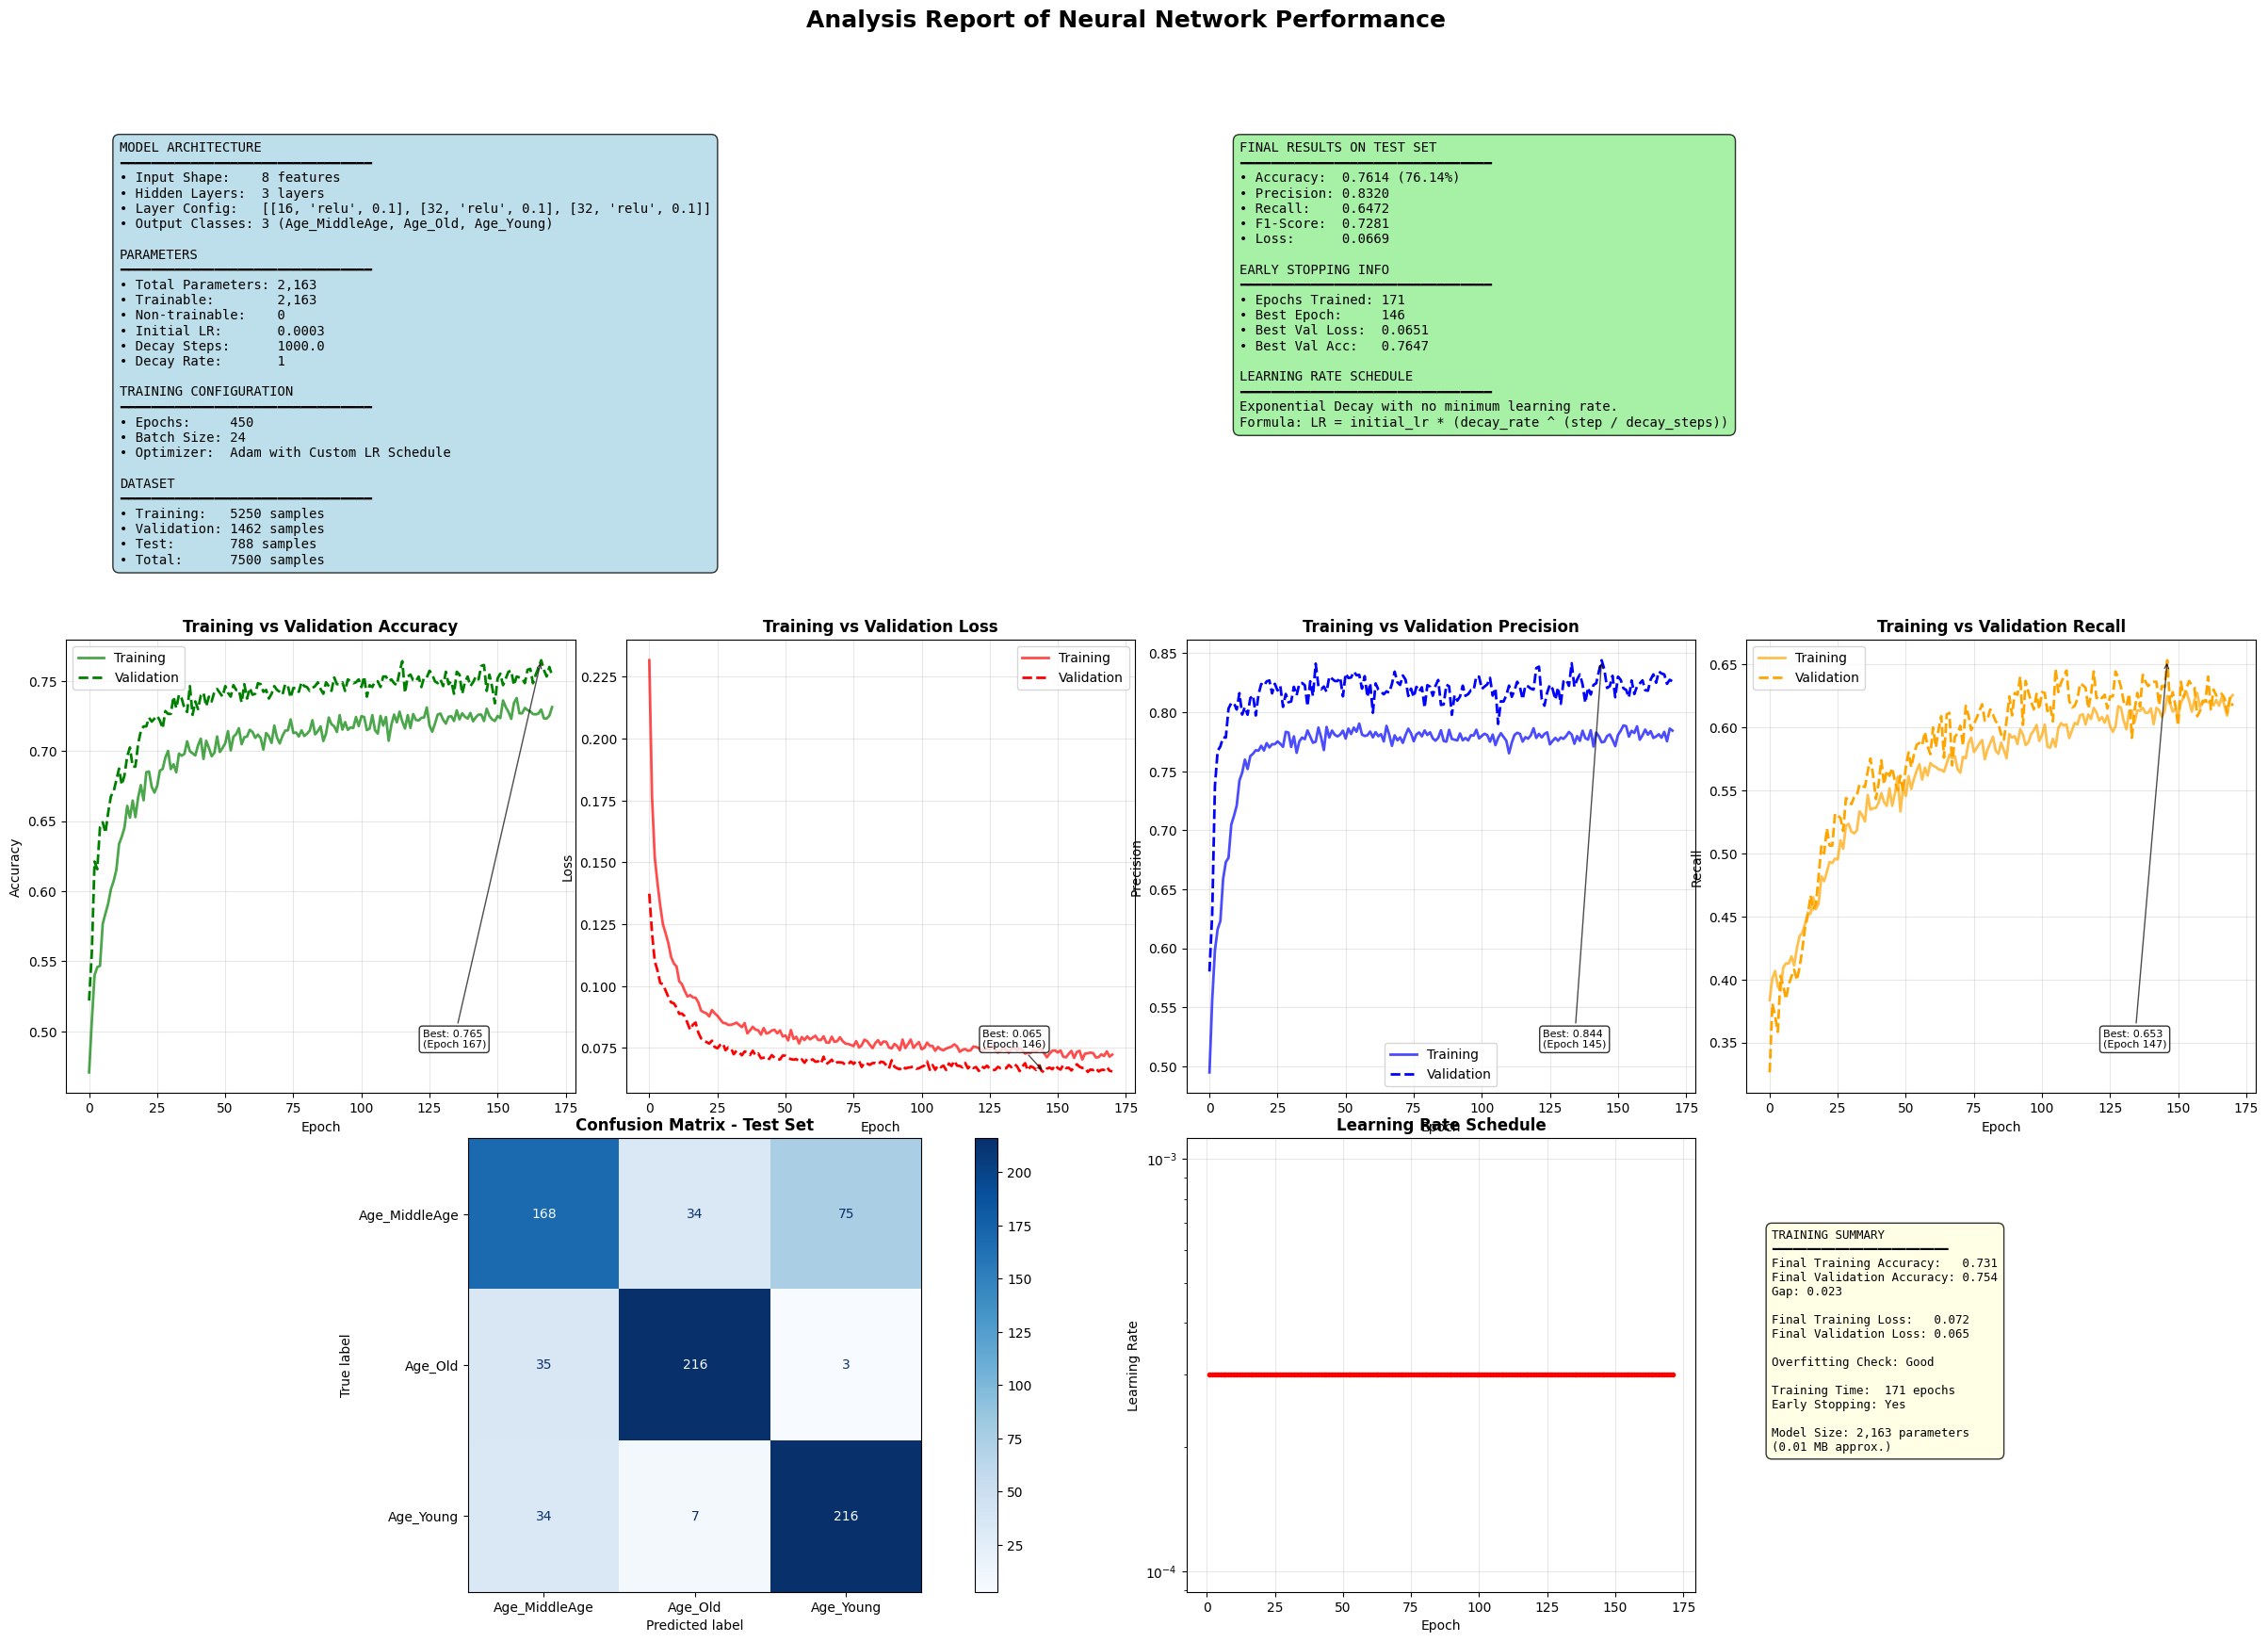

In [22]:
## 6: Visualizzazione dei risultati migliorata

eval = model.evaluate(X_test, Y_test, return_dict = True)

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1)
y_true_classes = np.argmax(Y_test.values, axis = 1)
cm = confusion_matrix(y_true_classes, y_pred_classes)

print("Test set evaluation:")
print(f"Precision: {eval['Precision']:.4f}")
print(f"Recall:    {eval['Recall']:.4f}")
print(f"Loss:      {eval['loss']:.4f}")
print(f"Accuracy:  {eval['accuracy']:.4f}")
print(f"F1-score:  {2 * (eval['Precision'] * eval['Recall']) / (eval['Precision'] + eval['Recall']):.4f}")

# Funzione per creare visualizzazione completa
def create_comprehensive_visualization(model, history, eval_results, cm, Y, lr_schedule, net_layers, num_epochs, batch_size, X_train, X_val, X_test):
    """
    Crea una visualizzazione completa con informazioni del modello, statistiche di training e confusion matrix
    """
    # Configurazione figura con layout personalizzato
    fig = plt.figure(figsize=(30, 20))
    gs = fig.add_gridspec(3, 4, hspace=0.1, wspace=0.1)

    # Titolo principale
    fig.suptitle('Analysis Report of Neural Network Performance', fontsize=18, fontweight='bold', y=0.95)

    # 1. Informazioni sull'architettura del modello (in alto a sinistra)
    ax_info = fig.add_subplot(gs[0, :2])
    ax_info.axis('off')

    # Calcolo parametri del modello
    total_params = model.count_params()
    trainable_params = sum([layer.count_params() for layer in model.layers if layer.trainable])
    non_trainable_params = total_params - trainable_params

    # Informazioni sul learning rate
    #lr_info = f"Initial LR: {lr_decay.initial_learning_rate}\nDecay Steps: {lr_schedule.decay_steps}\nDecay Rate: {lr_schedule.decay_rate}\n" # Min LR: {lr_schedule.min_lr}

    # Testo delle informazioni del modello
    model_info = f"""MODEL ARCHITECTURE
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Input Shape:    {X_train.shape[1]} features
• Hidden Layers:  {len(net_layers)} layers
• Layer Config:   {net_layers}
• Output Classes: {Y.shape[1]} ({', '.join(Y.columns)})

PARAMETERS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Total Parameters: {total_params:,}
• Trainable:        {trainable_params:,}
• Non-trainable:    {non_trainable_params:,}
• Initial LR:       {lr_schedule.initial_learning_rate}
• Decay Steps:      {lr_schedule.decay_steps}
• Decay Rate:       {lr_schedule.decay_rate}

TRAINING CONFIGURATION
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Epochs:     {num_epochs}
• Batch Size: {batch_size}
• Optimizer:  Adam with Custom LR Schedule

DATASET
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Training:   {X_train.shape[0]} samples
• Validation: {X_val.shape[0]} samples
• Test:       {X_test.shape[0]} samples
• Total:      {X_train.shape[0] + X_val.shape[0] + X_test.shape[0]} samples"""

    ax_info.text(0.05, 1, model_info, transform=ax_info.transAxes, fontsize=10,
                verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))

    # 2. Metriche finali (in alto a destra)
    ax_metrics = fig.add_subplot(gs[0, 2:])
    ax_metrics.axis('off')

    f1_score = 2 * (eval_results['Precision'] * eval_results['Recall']) / (eval_results['Precision'] + eval_results['Recall'])

    metrics_text = f"""FINAL RESULTS ON TEST SET
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Accuracy:  {eval_results['accuracy']:.4f} ({(eval_results['accuracy']* 100):.2f}%)
• Precision: {eval_results['Precision']:.4f}
• Recall:    {eval_results['Recall']:.4f}
• F1-Score:  {f1_score:.4f}
• Loss:      {eval_results['loss']:.4f}

EARLY STOPPING INFO
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Epochs Trained: {len(history.history['loss'])}
• Best Epoch:     {np.argmin(history.history['val_loss']) + 1}
• Best Val Loss:  {min(history.history['val_loss']):.4f}
• Best Val Acc:   {max(history.history['val_accuracy']):.4f}

LEARNING RATE SCHEDULE
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Exponential Decay with no minimum learning rate.
Formula: LR = initial_lr * (decay_rate ^ (step / decay_steps))"""

    ax_metrics.text(0.05, 1, metrics_text, transform=ax_metrics.transAxes, fontsize=10,
                   verticalalignment='top', fontfamily='monospace',
                   bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgreen", alpha=0.8))

    # 3-6. Grafici delle metriche di training (riga centrale)
    metrics = [
        ('accuracy', 'val_accuracy', 'Accuracy', 'green'),
        ('loss', 'val_loss', 'Loss', 'red'),
        ('Precision', 'val_Precision', 'Precision', 'blue'),
        ('Recall', 'val_Recall', 'Recall', 'orange')
    ]

    for i, (train_metric, val_metric, title, color) in enumerate(metrics):
        ax = fig.add_subplot(gs[1, i])
        ax.plot(history.history[train_metric], label='Training', color=color, alpha=0.7, linewidth=2)
        ax.plot(history.history[val_metric], label='Validation', color=color, linestyle='--', linewidth=2)
        ax.set_title(f'Training vs Validation {title}', fontweight='bold')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(title)
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Aggiungi annotazione per il valore migliore
        if 'loss' in train_metric.lower():
            best_epoch = np.argmin(history.history[val_metric])
            best_value = min(history.history[val_metric])
        else:
            best_epoch = np.argmax(history.history[val_metric])
            best_value = max(history.history[val_metric])

        ax.annotate(f'Best: {best_value:.3f}\n(Epoch {best_epoch+1})',
                   xy=(best_epoch, best_value), xytext=(0.7, 0.1),
                   textcoords='axes fraction', fontsize=8,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
                   arrowprops=dict(arrowstyle='->', color='black', alpha=0.7))

    # 7. Confusion Matrix (in basso a sinistra)
    ax_cm = fig.add_subplot(gs[2, :2])
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=Y.columns)
    cm_display.plot(ax=ax_cm, cmap='Blues', values_format='d')
    ax_cm.set_title('Confusion Matrix - Test Set', fontweight='bold')

    # 8. Learning Rate Schedule Visualization (in basso al centro)
    ax_lr = fig.add_subplot(gs[2, 2])

    # Simula l'evoluzione del learning rate
    steps = np.arange(0, len(history.history['loss']) * 101, 101)  # 101 step per epoca
    lr_values = [float(lr_schedule(step)) for step in steps]
    epochs_lr = np.arange(1, len(lr_values) + 1)

    ax_lr.plot(epochs_lr, lr_values, 'r-', linewidth=2, marker='o', markersize=3)
    ax_lr.set_title('Learning Rate Schedule', fontweight='bold')
    ax_lr.set_xlabel('Epoch')
    ax_lr.set_ylabel('Learning Rate')
    ax_lr.set_yscale('log')
    ax_lr.grid(True, alpha=0.3)

    # 9. Training Summary (in basso a destra)
    ax_summary = fig.add_subplot(gs[2, 3])
    ax_summary.axis('off')

    # Calcola statistiche riassuntive
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]

    overfitting_indicator = "Good" if abs(final_train_acc - final_val_acc) < 0.05 else "Possible Overfitting"

    summary_text = f"""TRAINING SUMMARY
━━━━━━━━━━━━━━━━━━━━━━━━━
Final Training Accuracy:   {final_train_acc:.3f}
Final Validation Accuracy: {final_val_acc:.3f}
Gap: {abs(final_train_acc - final_val_acc):.3f}

Final Training Loss:   {final_train_loss:.3f}
Final Validation Loss: {final_val_loss:.3f}

Overfitting Check: {overfitting_indicator}

Training Time:  {len(history.history['loss'])} epochs
Early Stopping: {'Yes' if len(history.history['loss']) < num_epochs else 'No'}

Model Size: {total_params:,} parameters
({total_params * 4 / 1024 / 1024:.2f} MB approx.)"""

    ax_summary.text(0.05, 0.8, summary_text, transform=ax_summary.transAxes, fontsize=9,
                   verticalalignment='top', fontfamily='monospace',
                   bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", alpha=0.8))

    plt.tight_layout()
    return fig

# Chiamata della funzione di visualizzazione completa
fig = create_comprehensive_visualization(
    model=model,
    history=history,
    eval_results=eval,
    cm=cm,
    Y=Y,
    lr_schedule=lr_decay,
    net_layers=net_layers,
    num_epochs=num_epochs,
    batch_size=batch_size,
    X_train=X_train,
    X_val=X_val,
    X_test=X_test
)

plt.show()

# Opzione per salvare la figura
# fig.savefig('neural_network_analysis_report.png', dpi=300, bbox_inches='tight')